<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-27 18:20:22--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-05-27 18:20:22 (378 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

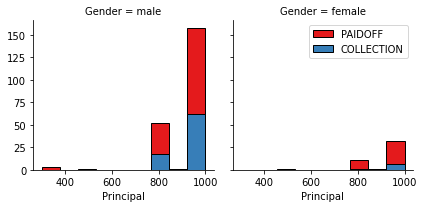

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

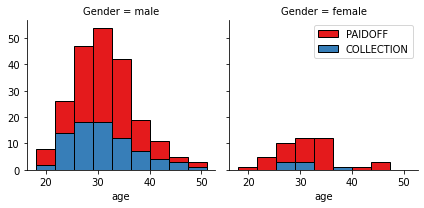

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


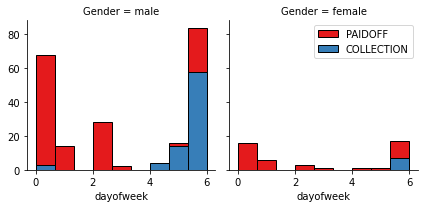

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: di

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
Train set Accuracy for k=4:  0.8152173913043478
Test set Accuracy for k=4:  0.6857142857142857


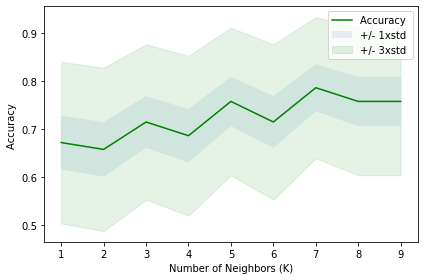

The best accuracy was with 0.7857142857142857 with k= 7


In [20]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Import Classifier
from sklearn.neighbors import KNeighborsClassifier

#Training
#Let's start the algorithm with k=4:
k = 4
#Train Model and Predict  
neigh4 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh4

#Predicting
#We can use the model to make predictions on the test set:
yhat4 = neigh4.predict(X_test)
yhat4[0:5]

#Accuracy Evaluation
from sklearn import metrics
print("Train set Accuracy for k=4: ", metrics.accuracy_score(y_train, neigh4.predict(X_train)))
print("Test set Accuracy for k=4: ", metrics.accuracy_score(y_test, yhat4))

#Looping 10 times to find the best k
#We can calculate the accuracy of KNN for different values of k.
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

#Plotting the multible values of k
#Plot the model accuracy for a different number of neighbors.
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

#Print the Result of the best k
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 




In [21]:
#Use the best accuracy k value of 7:

#Train Model and Predict  
kn=7
neigh7 = KNeighborsClassifier(n_neighbors = kn).fit(X_train,y_train)
neigh7

#Predicting
#We can use the model to make predictions on the test set:
yhat7 = neigh7.predict(X_test)
yhat7[0:5]

#Accuracy Evaluation when k=7
from sklearn import metrics
from sklearn.metrics import f1_score
print("Train set KNN Jaccard Accuracy: ", metrics.accuracy_score(y_train, neigh7.predict(X_train)))
print("Test set KNN Jaccard Accuracy: ", metrics.accuracy_score(y_test, neigh7.predict(X_test)))
print("Train set KNN F1 Accuracy:", f1_score(y_train, neigh7.predict(X_train), average='weighted'))
print("Test set KNN F1 Accuracy:", f1_score(y_test, neigh7.predict(X_test), average='weighted'))


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: di

Train set KNN Jaccard Accuracy:  0.8079710144927537
Test set KNN Jaccard Accuracy:  0.7857142857142857
Train set KNN F1 Accuracy: 0.8000194668761034
Test set KNN F1 Accuracy: 0.7766540244416351


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < Loose

DECISION TREE  

In [22]:
#Import Classifier
from sklearn.tree import DecisionTreeClassifier

#Train-Test Split
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Training
#Must create an instance of the DecisionTreeClassifier, called loanTree & then train
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(X_trainset, y_trainset)
loanTree

#Predicting
predTree = loanTree.predict(X_testset)
#Print out predicted and actual values
print(predTree[0:5])
print(y_testset[0:5])





Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


In [23]:
#Accuracy Evaluation
#Need to import matplotlib.pyplot
import matplotlib.pyplot as plt
print("Train set Decision Trees's Jaccard Accuracy: ", metrics.accuracy_score(y_trainset, loanTree.predict(X_trainset)))
print("Test set Decision Trees's Jaccard Accuracy: ", metrics.accuracy_score(y_testset, loanTree.predict(X_testset)))
print("Train set Decision Tree's F1 Accuracy: " , f1_score(y_trainset, loanTree.predict(X_trainset), average='weighted'))
print("Test set Decision Tree's F1 Accuracy: " , f1_score(y_testset, loanTree.predict(X_testset), average='weighted'))





Train set Decision Trees's Jaccard Accuracy:  0.7892561983471075
Test set Decision Trees's Jaccard Accuracy:  0.6538461538461539
Train set Decision Tree's F1 Accuracy:  0.7931024194847948
Test set Decision Tree's F1 Accuracy:  0.6666949930317142


In [24]:
#Visualize the Tree by taking comments out and running
#May need to install the following:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y
#Import from sklearn
#import sklearn.tree as tree

#tree.plot_tree(loanTree)
#plt.show()


# Support Vector Machine


In [25]:
#Train-Test Split
#Is already completed

#Import Classifier
from sklearn import svm
#Choose a kernel function as linear, polynomial, radial basis function(RBF), Sigmoid & train
svm_clf=svm.SVC(kernel='rbf').fit(X_train, y_train)

#Predicting
yhatSVM=svm_clf.predict(X_test)
yhatSVM[0:5]

#Accuracy Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhatSVM, labels=['PAIDOFF', 'COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhatSVM))



              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(

Confusion matrix, without normalization
[[48  7]
 [11  4]]


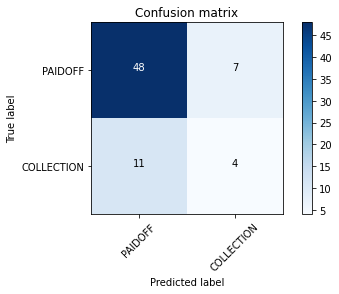

In [26]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [27]:
#Determine Accuracy Evaluation of Jaccard and F1 scores 
print("Train set SVM Jaccard Accuracy: ", metrics.accuracy_score(y_train, svm_clf.predict(X_train)))
print("Test set SVM Jaccard Accuracy: ", metrics.accuracy_score(y_test, svm_clf.predict(X_test)))
print("Train set SVM F1 Accuracy:" , f1_score(y_train, svm_clf.predict(X_train), average='weighted'))
print("Test set SVM F1 Accuracy:" , f1_score(y_test, svm_clf.predict(X_test), average='weighted'))


Train set SVM Jaccard Accuracy:  0.782608695652174
Test set SVM Jaccard Accuracy:  0.7428571428571429
Train set SVM F1 Accuracy: 0.7682165861513688
Test set SVM F1 Accuracy: 0.7275882012724117


# Logistic Regression


In [28]:
#Preprocessing of the data - target data (y) must be an integer
df['loan_status'].replace(to_replace=('PAIDOFF', 'COLLECTION'), value=[0,1], inplace=True)
df.head()

#Note: X and y have already been identified,normalized, 
#and made into a train & test set from prior application

#Import Classifier
from sklearn.linear_model import LogisticRegression

#Training
#Choose optimizer solver: 'newton-cg', 'liblinear', 'sag', 'saga', 'lbfgs'
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
lr

#Predicting
yhatLR = lr.predict(X_test)
yhatLR

#Perform predict proba estimates
yhatLR_prob = lr.predict_proba(X_test)
yhatLR_prob

#Accuracy Evaluation including log loss
from sklearn.metrics import log_loss
print("Train set LR Jaccard Accuracy: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print("Test set LR Jaccard Accuracy: ", metrics.accuracy_score(y_test, lr.predict(X_test)))
print("Train set LR F1 Accuracy:" , f1_score(y_train, lr.predict(X_train), average='weighted'))
print("Test set LR F1 Accuracy:" , f1_score(y_test, lr.predict(X_test), average='weighted'))
print("Train set LR Log_Loss:", log_loss(y_train, lr.predict_proba(X_train)))
print("Test set LR Log_Loss:", log_loss(y_test, lr.predict_proba(X_test)))


Train set LR Jaccard Accuracy:  0.7572463768115942
Test set LR Jaccard Accuracy:  0.6857142857142857
Train set LR F1 Accuracy: 0.7341146337750953
Test set LR F1 Accuracy: 0.6670522459996144
Train set LR Log_Loss: 0.5513966315177746
Test set LR Log_Loss: 0.5772287609479654


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

# Model Evaluation using Test set


In [29]:
#from sklearn.metrics import jaccard_score *Used sklearn metrics.accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [30]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-27 18:20:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-27 18:20:25 (138 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [32]:
test_df.shape

(54, 10)

In [33]:
#Convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
#test_df.head()

In [34]:
#use Feature binarization to set a threshold value less than day 4 of week
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)


test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
#test_df.head()

In [35]:
#Convert category to numeric: male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#test_df.head()

In [36]:
#Use one hot encoding to convert category to binary
FeatureX = test_df[['Principal','terms','age','Gender','weekend']]
FeatureX = pd.concat([FeatureX,pd.get_dummies(test_df['education'])], axis=1)
FeatureX.drop(['Master or Above'], axis = 1,inplace=True)
FeatureX.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [37]:
#Define X
X_ltest= FeatureX
X_ltest[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [38]:
#Define our Labels 
y_ltest= test_df['loan_status'].values
y_ltest[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [39]:
#Normalize the data
X_ltest = preprocessing.StandardScaler().fit(X_ltest).transform(X_ltest)
X_ltest[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [40]:
#Predict KNN using loan_test dataset & get metrics
pred_knn = neigh7.predict(X_ltest)
#KNN Metrics
knn_jaccard = accuracy_score(y_ltest, pred_knn)
knn_f1 = f1_score(y_ltest, pred_knn, average='weighted')

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


In [41]:
#Predict DecisionTree using loan_test dataset & get metrics
pred_dt = loanTree.predict(X_ltest)
#Decision Tree Metrics
dt_jaccard = metrics.accuracy_score(y_ltest, pred_dt)
dt_f1 = f1_score(y_ltest, pred_dt, average='weighted')

In [42]:
#Predict SVM using loan_test dataset & get metrics
pred_svm = svm_clf.predict(X_ltest)
#SVM Metrics
svm_jaccard = metrics.accuracy_score(y_ltest, pred_svm)
svm_f1 = f1_score(y_ltest, pred_svm, average='weighted')

In [43]:
#Predict LRusing loan_test dataset & get metrics
pred_lr = lr.predict(X_ltest)
#LR Metrics
lr_jaccard = metrics.accuracy_score(y_ltest, pred_lr)
lr_f1 = f1_score(y_ltest, pred_lr, average='weighted')
#Compute proba to also determine log loss
pred_lrproba = lr.predict_proba(X_ltest)
lr_logloss = log_loss(y_ltest, pred_lrproba)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [44]:
#Print Report
print(" ")
print(" ")
print("*******************************************  REPORT  *************************************")
print(" ")
print("                     Jaccard                       F1-Score                  Logloss      ")
print("KNN                ", knn_jaccard , "       ",  knn_f1 , "             N/A")
print("Decision Tree      ", dt_jaccard , "       ", dt_f1 , "             N/A")
print("SVM                ", svm_jaccard , "       ",  svm_f1 , "             N/A")
print("Logistic Regression", lr_jaccard , "       ", lr_f1 , "     ", lr_logloss)
print(" ")
print("******************************************************************************************")

 
 
*******************************************  REPORT  *************************************
 
                     Jaccard                       F1-Score                  Logloss      
KNN                 0.6666666666666666         0.6328400281888654              N/A
Decision Tree       0.7777777777777778         0.7823361823361823              N/A
SVM                 0.7962962962962963         0.7583503077293734              N/A
Logistic Regression 0.7407407407407407         0.6604267310789049       0.5672153379912981
 
******************************************************************************************


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
